In [1]:
%matplotlib inline

import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy.stats import pearsonr

from scipy.cluster.hierarchy import linkage
import scipy.spatial.distance as ssd

import seaborn as sns
import sys
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_selection import mutual_info_classif
import os
from cnmf import cNMF, save_df_to_npz, load_df_from_npz
import harmonypy
from adjustText import adjust_text

from matplotlib.patches import Patch
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle
from matplotlib.pyplot import rc_context
import matplotlib.colors as clr


def save_df_to_text(obj, filename):
    obj.to_csv(filename, sep='\t')


In [2]:
sys.path.append('../../Code/')
from utils import read_dataset_log

In [19]:
cgep_paths = read_dataset_log('cGEP Paths').loc[0, :]

In [90]:
cgep_info = read_dataset_log('cGEP_Name')
cgep_info.index = cgep_info['Short_Name']
cgep_info.head()

,cGep_Name,Long_Name,Short_Name,New_Short_Name,Needs Review,Class,Num_Datasets,Notes,Reviewed,Filter
Short_Name,,,,,,,,,,
Cytoskeleton,COMBAT_Cytoskeleton,Actin Cytoskeleton,Cytoskeleton,Cytoskeleton,NaN,Functional,7.0,NaN,Y,NaN
CD8-EM,CD8_EM,CD8 Effector Memory,CD8-EM,CD8-EM,Y,Lineage,7.0,Need to confirm overlap with gating since the ...,Y,NaN
CellCycle-G2M,CellCycle-G2M,Cell Cycle G2M Phase,CellCycle-G2M,CellCycle-G2M,NaN,Functional,7.0,NaN,Y,NaN
CellCycle-S,CellCycle-S,Cell Cycle S Phase,CellCycle-S,CellCycle-S,NaN,Functional,7.0,NaN,Y,NaN
Cytotoxic,Cytotoxic,Cytotoxic,Cytotoxic,Cytotoxic,NaN,Functional,7.0,NaN,Y,NaN


In [91]:
cgep_rename = dict(zip(cgep_info['cGep_Name'], cgep_info['Short_Name']))

In [92]:
spectra = pd.read_csv(cgep_paths.loc['tpm_varnorm_spectra'], sep='\t', index_col=0)
hvg = open(cgep_paths.loc['merged_hvgs']).read().split('\n')
spectra_hvg = spectra[hvg]
spectra_hvg_ren = spectra_hvg.rename(index=cgep_rename)
spectra_hvg_ren.head()

,A1BG,AARD,AARSD1,ABCA1,ABCB1,ABCC1,ABHD17A,ABHD5,ABI2,ABI3,...,ZNF829,ZNF836,ZNF891,ZNF90,ZNRF1,ZP1,ZRSR2,ZWILCH,ZWINT,ZYX
CellCycle-G2M,0.017981,0.212071,0.154728,0.032342,0.020914,0.254284,0.586384,0.459427,0.190882,0.654982,...,0.200448,0.213989,0.071207,0.226593,0.234918,0.006449,0.255557,1.503474,4.472711,1.082954
Translation,0.425929,0.000000,0.118040,0.004785,0.000000,0.000000,0.217525,0.000000,0.043314,0.000000,...,0.011585,0.074059,0.035688,0.163244,0.000000,0.000000,0.047273,0.000000,0.000000,0.000000
HLA,0.173398,0.136964,0.024736,0.036903,0.000000,0.199120,0.551431,0.519134,0.020949,0.116380,...,0.035730,0.218837,0.000000,0.000000,0.552103,0.000000,0.292846,0.070490,0.000000,1.445679
ISG,0.004394,0.000000,0.172218,0.154956,0.000000,0.162081,0.232270,0.112165,0.141695,0.281308,...,0.133766,0.294455,0.057393,0.147842,0.125829,0.000000,0.977933,0.133939,0.000000,0.312110
Mito,0.099591,0.000000,0.525361,0.138210,0.030515,0.500529,0.277639,0.319260,0.585441,0.000000,...,0.155241,0.244798,0.590293,0.085623,0.000000,0.000000,0.355352,0.047609,0.000000,0.113418


In [93]:
spectra_corr = spectra_hvg_ren.T.corr().unstack().reset_index()
spectra_corr.columns = ['cGEP1', 'cGEP2', 'R']
spectra_corr.head()

,cGEP1,cGEP2,R
0,CellCycle-G2M,CellCycle-G2M,1.000000
1,CellCycle-G2M,Translation,0.004797
2,CellCycle-G2M,HLA,0.063777
3,CellCycle-G2M,ISG,0.003093
4,CellCycle-G2M,Mito,0.008139


In [94]:
dataset_paths = read_dataset_log('Dataset Paths')
dataset_paths.index = dataset_paths['dataset']

In [95]:
from sklearn.metrics.pairwise import pairwise_distances 

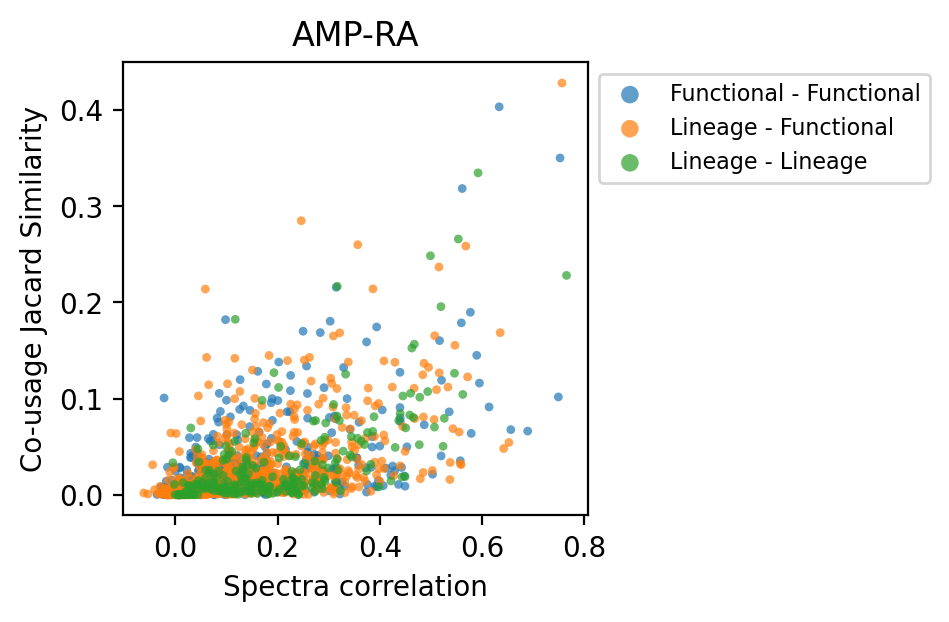

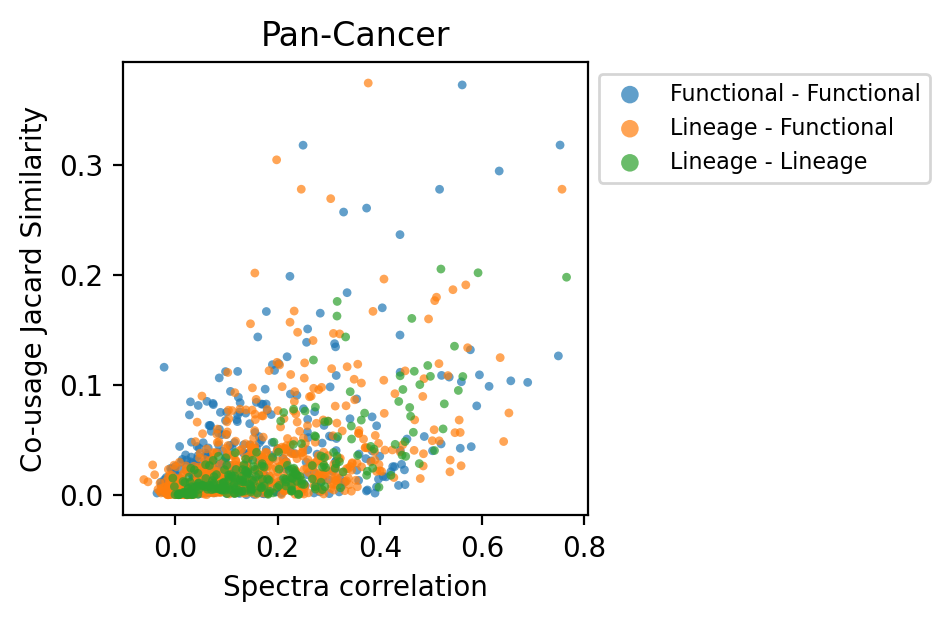

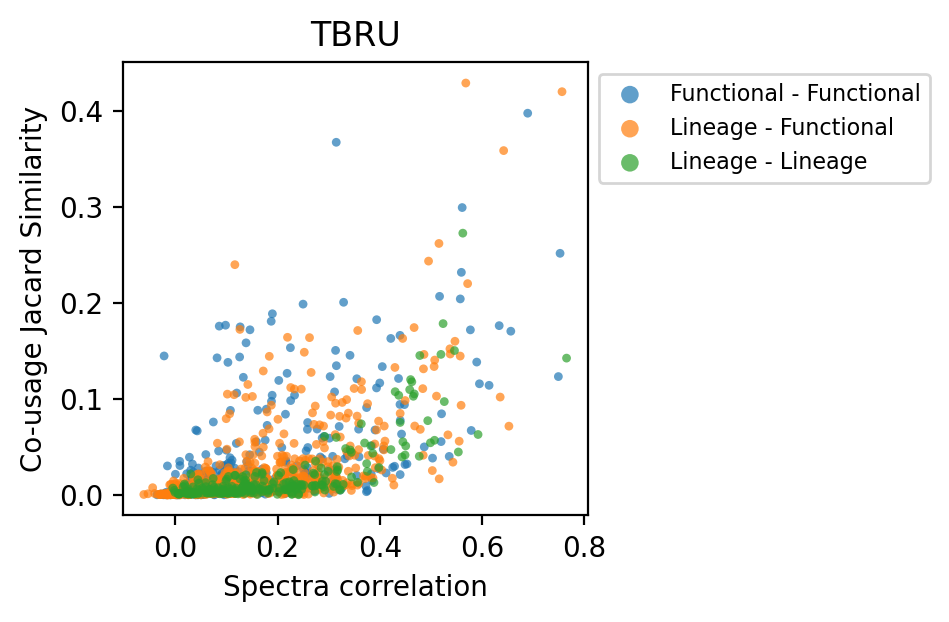

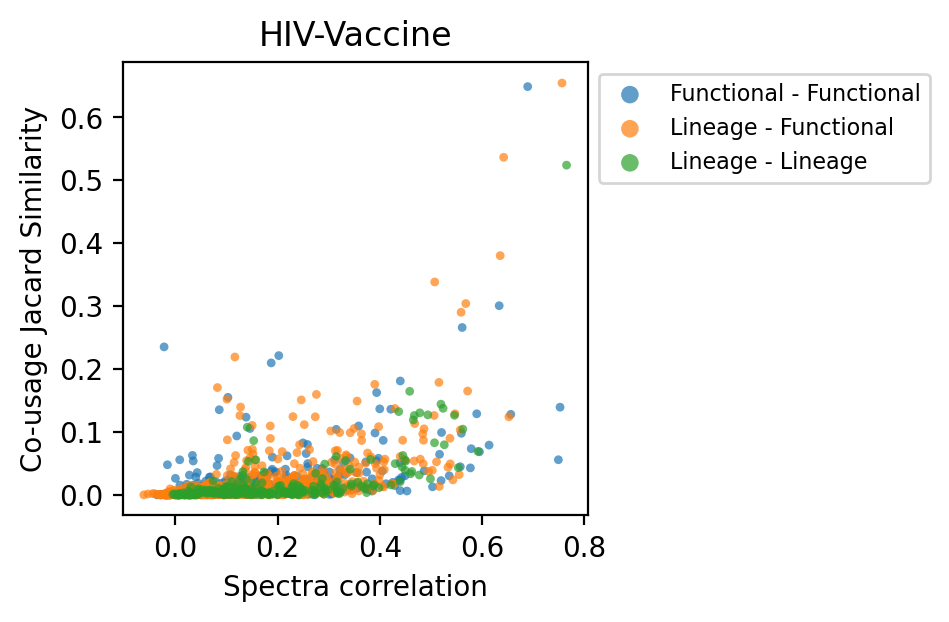

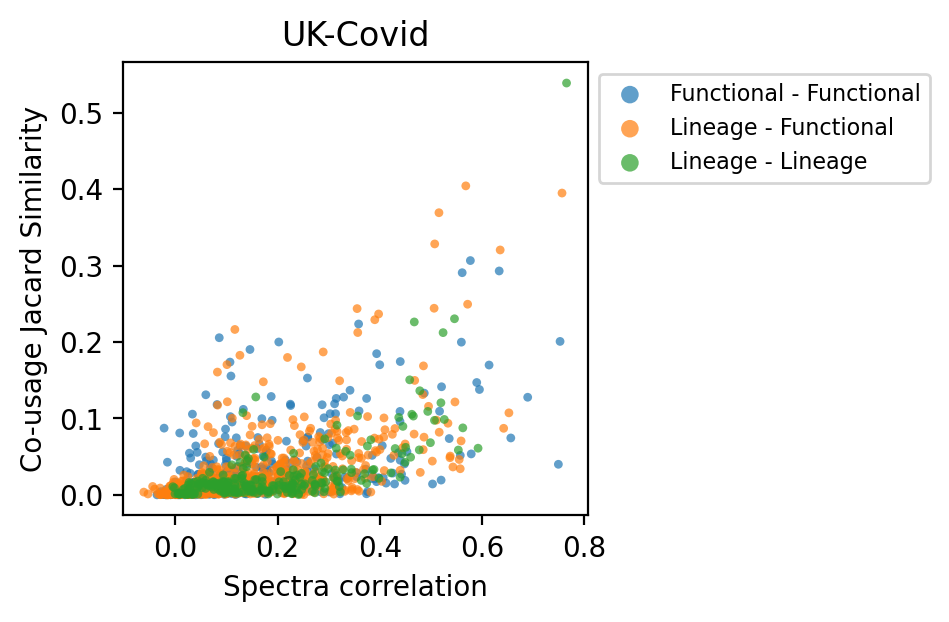

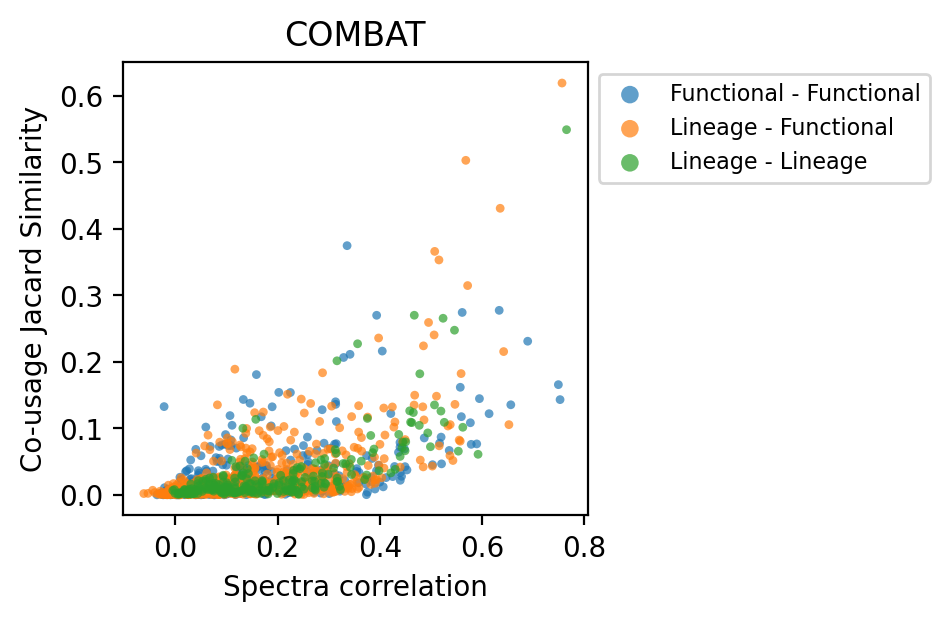

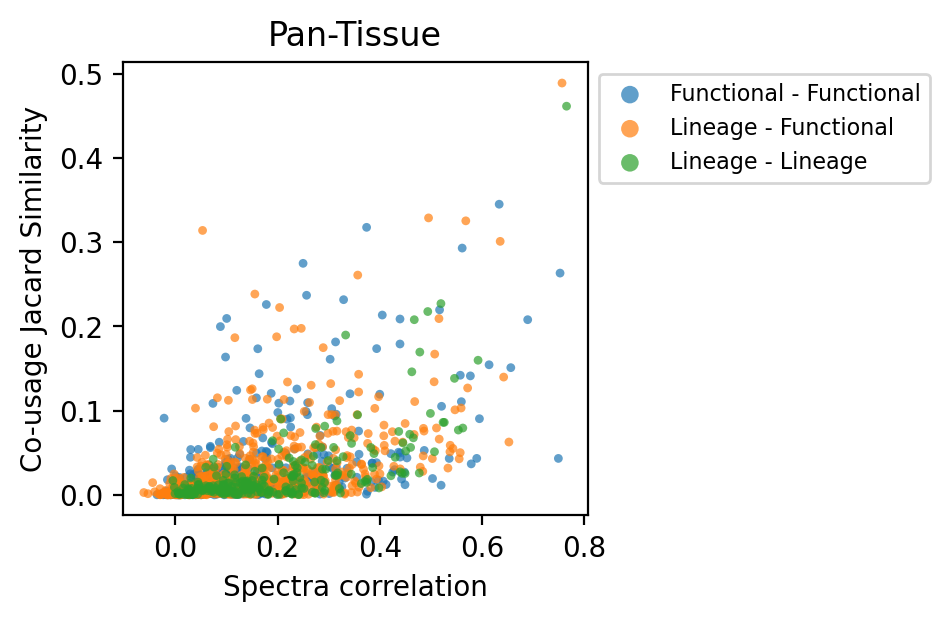

In [109]:
thresh = 0.05
results = {}
for d in dataset_paths.index[dataset_paths['dataset_type'] == 'discovery']:
    usage = pd.read_csv(dataset_paths.loc[d, 'tcat_fn'], sep='\t', index_col=0)
    usage = usage.rename(columns = cgep_rename)
    usage_norm = usage.div(usage.sum(axis=1), axis=0)
    usage_norm_bin = (usage_norm>thresh)
    jacard = pd.DataFrame(1 - pairwise_distances(usage_norm_bin.T.values, metric="jaccard", n_jobs=-1), index=usage.columns, columns=usage.columns)
    jacard_unstack = jacard.unstack().reset_index()
    jacard_unstack.columns = ['cGEP1', 'cGEP2', 'Jacard']
    merged = pd.merge(left=spectra_corr, right=jacard_unstack, on=['cGEP1', 'cGEP2'], how='inner')
    merged = merged.loc[merged['cGEP1']<merged['cGEP2'], :]
    merged = pd.merge(left=merged, right=cgep_info[['Class']], left_on='cGEP1', right_index=True, how='left').rename(columns={'Class':'cGEP1_Class'})
    merged = pd.merge(left=merged, right=cgep_info[['Class']], left_on='cGEP2', right_index=True, how='left').rename(columns={'Class':'cGEP2_Class'})
    merged['cGEP1_Class'] = merged['cGEP1_Class'].replace({'Artifact':'Functional', 'Doublet Lineage':'Lineage'})
    merged['cGEP2_Class'] = merged['cGEP2_Class'].replace({'Artifact':'Functional', 'Doublet Lineage':'Lineage'})
    merged['Category'] = 'Lineage - Functional'
    merged.loc[(merged['cGEP1_Class']=='Lineage') & (merged['cGEP2_Class']=='Lineage'), 'Category'] = 'Lineage - Lineage'
    merged.loc[(merged['cGEP1_Class']=='Functional') & (merged['cGEP2_Class']=='Functional'), 'Category'] = 'Functional - Functional'    
    results[d] = merged
    (fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200)
    
    for (k,g) in merged.groupby('Category'):
        ax.scatter(g['R'], g['Jacard'], s=10, edgecolor='None', alpha=0.7, label=k)
        
    ax.set_xlabel('Spectra correlation')
    ax.set_ylabel('Co-usage Jacard Similarity')
    ax.set_title(d)
    ax.legend(bbox_to_anchor=(1,1), markerscale=2, fontsize=8)

In [112]:
for d in dataset_paths.index[dataset_paths['dataset_type'] == 'discovery']:
    merged = results[d]
    print(d)
    
    ind = ((merged['cGEP1']=='Th17') | (merged['cGEP2']=='Th17')) & ((merged['cGEP1']=='Th17-2') | (merged['cGEP2']=='Th17-2'))
    display(merged.loc[ind, :])    
    display(merged.sort_values(by='Jacard', ascending=False).head(20))

AMP-RA


,cGEP1,cGEP2,R,Jacard,cGEP1_Class,cGEP2_Class,Category
1393,Th17,Th17-2,0.341882,0.041522,Lineage,Lineage,Lineage - Lineage


,cGEP1,cGEP2,R,Jacard,cGEP1_Class,cGEP2_Class,Category
1249,CD4-Naive,Translation,0.756287,0.428163,Lineage,Functional,Lineage - Functional
13,CellCycle-G2M,CellCycle-Late-S,0.633381,0.403438,Functional,Functional,Functional - Functional
1241,IEG2,YPEL5/JUNB,0.752467,0.350270,Functional,Functional,Functional - Functional
2694,Tfh-1,Tfh-2,0.592027,0.334745,Lineage,Lineage,Lineage - Lineage
683,CellCycle-Late-S,CellCycle-S,0.560978,0.318510,Functional,Functional,Functional - Functional
1171,CD8-EM,MALAT1,0.246135,0.284990,Lineage,Functional,Lineage - Functional
1082,CD4-CM,Tfh-2,0.553460,0.266020,Lineage,Lineage,Lineage - Lineage
1293,CD4-Naive,YPEL5/JUNB,0.356644,0.260060,Lineage,Functional,Lineage - Functional
1152,CD8-EM,Cytotoxic,0.568043,0.258660,Lineage,Functional,Lineage - Functional
1091,CD4-CM,Tfh-1,0.498841,0.248584,Lineage,Lineage,Lineage - Lineage


Pan-Cancer


,cGEP1,cGEP2,R,Jacard,cGEP1_Class,cGEP2_Class,Category
1393,Th17,Th17-2,0.341882,0.09373,Lineage,Lineage,Lineage - Lineage


,cGEP1,cGEP2,R,Jacard,cGEP1_Class,cGEP2_Class,Category
2261,OX40/EBI3-Activation,Treg,0.377133,0.374128,Functional,Lineage,Lineage - Functional
683,CellCycle-Late-S,CellCycle-S,0.560978,0.372402,Functional,Functional,Functional - Functional
1241,IEG2,YPEL5/JUNB,0.752467,0.317782,Functional,Functional,Functional - Functional
1223,IEG2,MALAT1,0.249691,0.317653,Functional,Functional,Functional - Functional
2103,CD8-Trm-Like,IEG2,0.197949,0.304367,Lineage,Functional,Lineage - Functional
13,CellCycle-G2M,CellCycle-Late-S,0.633381,0.294208,Functional,Functional,Functional - Functional
1171,CD8-EM,MALAT1,0.246135,0.277661,Lineage,Functional,Lineage - Functional
1249,CD4-Naive,Translation,0.756287,0.277655,Lineage,Functional,Lineage - Functional
2519,CD40LG/TXNIP,IEG2,0.516728,0.277597,Functional,Functional,Functional - Functional
1167,CD8-EM,IEG2,0.303771,0.269092,Lineage,Functional,Lineage - Functional


TBRU


,cGEP1,cGEP2,R,Jacard,cGEP1_Class,cGEP2_Class,Category
1393,Th17,Th17-2,0.341882,0.046776,Lineage,Lineage,Lineage - Lineage


,cGEP1,cGEP2,R,Jacard,cGEP1_Class,cGEP2_Class,Category
1152,CD8-EM,Cytotoxic,0.568043,0.428920,Lineage,Functional,Lineage - Functional
1249,CD4-Naive,Translation,0.756287,0.419904,Lineage,Functional,Lineage - Functional
2289,TXNIP/H1FX,Translation,0.689146,0.397496,Functional,Functional,Functional - Functional
1408,MALAT1,Mito,0.314573,0.367209,Functional,Functional,Functional - Functional
1292,CD4-Naive,TXNIP/H1FX,0.642109,0.358562,Lineage,Functional,Lineage - Functional
683,CellCycle-Late-S,CellCycle-S,0.560978,0.299227,Functional,Functional,Functional - Functional
1064,CD4-CM,CD4-Naive,0.562211,0.272557,Lineage,Lineage,Lineage - Lineage
1688,BCL2-Survival,CD4-Naive,0.515519,0.261830,Functional,Lineage,Lineage - Functional
1241,IEG2,YPEL5/JUNB,0.752467,0.251575,Functional,Functional,Functional - Functional
1296,CD4-Naive,CD40LG/TXNIP,0.495168,0.243455,Lineage,Functional,Lineage - Functional


HIV-Vaccine


,cGEP1,cGEP2,R,Jacard,cGEP1_Class,cGEP2_Class,Category
1393,Th17,Th17-2,0.341882,0.040909,Lineage,Lineage,Lineage - Lineage


,cGEP1,cGEP2,R,Jacard,cGEP1_Class,cGEP2_Class,Category
1249,CD4-Naive,Translation,0.756287,0.654420,Lineage,Functional,Lineage - Functional
2289,TXNIP/H1FX,Translation,0.689146,0.648758,Functional,Functional,Functional - Functional
1292,CD4-Naive,TXNIP/H1FX,0.642109,0.536367,Lineage,Functional,Lineage - Functional
1276,CD4-Naive,CD8-Naive,0.765148,0.523925,Lineage,Lineage,Lineage - Lineage
1457,CD8-Naive,Translation,0.635316,0.380154,Lineage,Functional,Lineage - Functional
433,Cytotoxic,NK-like,0.507214,0.338277,Functional,Lineage,Lineage - Functional
1152,CD8-EM,Cytotoxic,0.568043,0.303998,Lineage,Functional,Lineage - Functional
13,CellCycle-G2M,CellCycle-Late-S,0.633381,0.300546,Functional,Functional,Functional - Functional
1500,CD8-Naive,TXNIP/H1FX,0.558847,0.290157,Lineage,Functional,Lineage - Functional
683,CellCycle-Late-S,CellCycle-S,0.560978,0.265957,Functional,Functional,Functional - Functional


UK-Covid


,cGEP1,cGEP2,R,Jacard,cGEP1_Class,cGEP2_Class,Category
1393,Th17,Th17-2,0.341882,0.051965,Lineage,Lineage,Lineage - Lineage


,cGEP1,cGEP2,R,Jacard,cGEP1_Class,cGEP2_Class,Category
1276,CD4-Naive,CD8-Naive,0.765148,0.538983,Lineage,Lineage,Lineage - Lineage
1152,CD8-EM,Cytotoxic,0.568043,0.404403,Lineage,Functional,Lineage - Functional
1249,CD4-Naive,Translation,0.756287,0.395007,Lineage,Functional,Lineage - Functional
1688,BCL2-Survival,CD4-Naive,0.515519,0.369275,Functional,Lineage,Lineage - Functional
433,Cytotoxic,NK-like,0.507214,0.328417,Functional,Lineage,Lineage - Functional
1457,CD8-Naive,Translation,0.635316,0.320520,Lineage,Functional,Lineage - Functional
1137,IEG,YPEL5/JUNB,0.576999,0.306662,Functional,Functional,Functional - Functional
13,CellCycle-G2M,CellCycle-Late-S,0.633381,0.293043,Functional,Functional,Functional - Functional
683,CellCycle-Late-S,CellCycle-S,0.560978,0.290773,Functional,Functional,Functional - Functional
422,Cytotoxic,gdT-Blood,0.571637,0.249515,Functional,Lineage,Lineage - Functional


COMBAT


,cGEP1,cGEP2,R,Jacard,cGEP1_Class,cGEP2_Class,Category
1393,Th17,Th17-2,0.341882,0.041646,Lineage,Lineage,Lineage - Lineage


,cGEP1,cGEP2,R,Jacard,cGEP1_Class,cGEP2_Class,Category
1249,CD4-Naive,Translation,0.756287,0.619301,Lineage,Functional,Lineage - Functional
1276,CD4-Naive,CD8-Naive,0.765148,0.549126,Lineage,Lineage,Lineage - Lineage
1152,CD8-EM,Cytotoxic,0.568043,0.503062,Lineage,Functional,Lineage - Functional
1457,CD8-Naive,Translation,0.635316,0.430925,Lineage,Functional,Lineage - Functional
374,CellCycle-S,Early-Activation,0.335792,0.374743,Functional,Functional,Functional - Functional
433,Cytotoxic,NK-like,0.507214,0.366136,Functional,Lineage,Lineage - Functional
1688,BCL2-Survival,CD4-Naive,0.515519,0.353242,Functional,Lineage,Lineage - Functional
422,Cytotoxic,gdT-Blood,0.571637,0.314725,Functional,Lineage,Lineage - Functional
13,CellCycle-G2M,CellCycle-Late-S,0.633381,0.277475,Functional,Functional,Functional - Functional
683,CellCycle-Late-S,CellCycle-S,0.560978,0.274319,Functional,Functional,Functional - Functional


Pan-Tissue


,cGEP1,cGEP2,R,Jacard,cGEP1_Class,cGEP2_Class,Category
1393,Th17,Th17-2,0.341882,0.070423,Lineage,Lineage,Lineage - Lineage


,cGEP1,cGEP2,R,Jacard,cGEP1_Class,cGEP2_Class,Category
1249,CD4-Naive,Translation,0.756287,0.489066,Lineage,Functional,Lineage - Functional
1276,CD4-Naive,CD8-Naive,0.765148,0.461564,Lineage,Lineage,Lineage - Lineage
13,CellCycle-G2M,CellCycle-Late-S,0.633381,0.345149,Functional,Functional,Functional - Functional
1296,CD4-Naive,CD40LG/TXNIP,0.495168,0.328897,Lineage,Functional,Lineage - Functional
1152,CD8-EM,Cytotoxic,0.568043,0.325425,Lineage,Functional,Lineage - Functional
1225,IEG2,RGCC/MYADM,0.373974,0.317695,Functional,Functional,Functional - Functional
2095,CD8-Trm-Like,HeatShock,0.053047,0.314025,Lineage,Functional,Lineage - Functional
1457,CD8-Naive,Translation,0.635316,0.301048,Lineage,Functional,Lineage - Functional
683,CellCycle-Late-S,CellCycle-S,0.560978,0.293067,Functional,Functional,Functional - Functional
1223,IEG2,MALAT1,0.249691,0.274948,Functional,Functional,Functional - Functional
